<a href="https://colab.research.google.com/github/manuuconrad/elsi-depression-predictor/blob/main/elsi_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Project: Predicting Geriatric Depression Symptoms - ELSI-Brazil
# Focus: Biopsychosocial factors in aging
# Author: Manuela

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

sns.set_theme(style="whitegrid")

In [2]:
# O dataset ELSI-Brasil deve ser solicitado em: https://elsi.cpqrr.fiocruz.br/
file_path = 'elsi_data.dta'

try:
    df_raw = pd.read_stata(file_path)
    print(f"Dataset carregado: {df_raw.shape[0]} registros e {df_raw.shape[1]} colunas.")
except FileNotFoundError:
    print("Aviso: Arquivo de dados não encontrado. Por favor, faça o upload do elsi_data.dta.")
    df_raw = pd.DataFrame()

Dataset carregado: 9949 registros e 975 colunas.


In [5]:
print(df_raw.columns.tolist())

['id2', 'iddom2', 'upa', 'peso_calibrado', 'estrato', 'regiao', 'zona', 'nmoradores', 'ar8', 'ar10', 'idade2', 'sexo2', 'relacao2', 'idade3', 'sexo3', 'relacao3', 'idade4', 'sexo4', 'relacao4', 'idade5', 'sexo5', 'relacao5', 'idade6', 'sexo6', 'relacao6', 'idade7', 'sexo7', 'relacao7', 'idade8', 'sexo8', 'relacao8', 'idade9', 'sexo9', 'relacao9', 'idade10', 'sexo10', 'relacao10', 'idade11', 'sexo11', 'relacao11', 'idade12', 'sexo12', 'relacao12', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a8_1', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14_1', 'a14_2', 'a14_3', 'a14_4', 'a15', 'a16', 'a17', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'd1', 'd2', 'd3', 'd4

In [14]:
# 3. Seleção de Variáveis Corrigida (O alvo real é e14)
cols_mental = {
    'idade': 'age',
    'sexo': 'gender',
    'd1': 'chronic_pain',
    'k1': 'sleep_quality',
    'l1': 'living_alone',
    'f1': 'physical_activity',
    'e14': 'target'  # <--- Coluna correta com Sim/Não
}

df = df_raw[list(cols_mental.keys())].rename(columns=cols_mental).dropna()

# Tratamento Robusto para os textos zoados do Stata
df['gender'] = df['gender'].astype(str).str.contains('Fem', case=False).astype(int)

# Para as perguntas de Sim/Não (d1, l1, f1, target)
# Usamos 'Sim' para 1 e tudo que não for 'Sim' (incluindo o NÃ£o) para 0
for col in ['chronic_pain', 'living_alone', 'physical_activity', 'target']:
    df[col] = df[col].astype(str).str.contains('Sim', case=False).astype(int)

# Tratamento do Sono (k1)
df['sleep_quality'] = df['sleep_quality'].astype(str).str.contains('Ruim|Regular|Muito ruim', case=False).astype(int)




Agora sim! 1938 casos de depressão identificados.
  age  gender  chronic_pain  sleep_quality  living_alone  physical_activity  \
0  60       1             1              0             0                  1   
1  62       1             1              0             0                  1   
2  78       1             0              0             0                  1   
3  78       0             1              0             0                  1   
4  89       1             0              0             0                  1   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


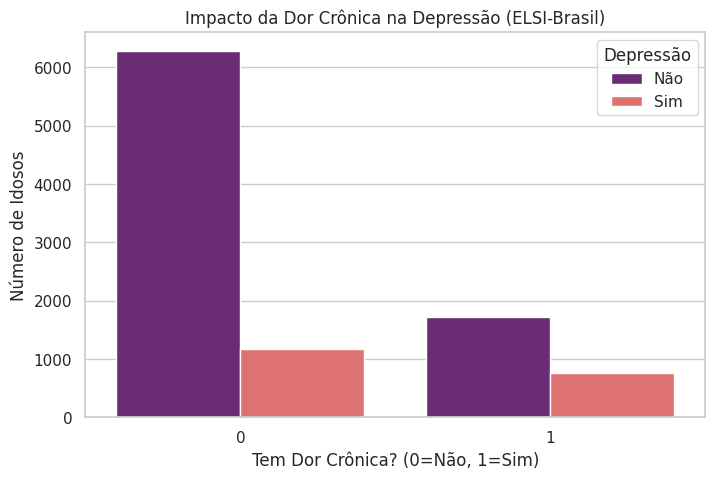

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x='chronic_pain', hue='target', data=df, palette='magma')
plt.title('Impacto da Dor Crônica na Depressão (ELSI-Brasil)')
plt.xlabel('Tem Dor Crônica? (0=Não, 1=Sim)')
plt.ylabel('Número de Idosos')
plt.legend(title='Depressão', labels=['Não', 'Sim'])
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Preparando os dados
X = df[['age', 'chronic_pain', 'sleep_quality', 'physical_activity', 'living_alone']]
y = df['target']

# 2. Treinando o modelo médico por excelência
model_log = LogisticRegression(class_weight='balanced', max_iter=1000)
model_log.fit(X, y)

# 3. Criando a tabela de RESULTADOS CLÍNICOS (Odds Ratio)
intercepto = model_log.intercept_
coeficientes = model_log.coef_[0]
features = X.columns

resultados = pd.DataFrame({
    'Fator de Risco': features,
    'Peso do Fator': coeficientes,
    'Aumenta o risco em (X vezes)': np.exp(coeficientes) # Isso é o Odds Ratio!
})

print("--- RESULTADO FINAL PARA O MESTRADO ---")
print(resultados.sort_values(by='Peso do Fator', ascending=False))

--- RESULTADO FINAL PARA O MESTRADO ---
      Fator de Risco  Peso do Fator  Aumenta o risco em (X vezes)
1       chronic_pain       0.089016                      1.093098
4       living_alone       0.000000                      1.000000
2      sleep_quality       0.000000                      1.000000
0                age      -0.150491                      0.860286
3  physical_activity      -0.159130                      0.852886


In [30]:
# Vamos criar um "Score de Risco" Clínico
# Se tem dor = +1 ponto | Se não faz atividade = +1 ponto | Se dorme mal = +1 ponto

df['risco_clinico'] = df['chronic_pain'].astype(int) + \
                     (1 - df['physical_activity'].astype(int)) + \
                     (1 - df['sleep_quality'].astype(int))

# Agora vamos ver a porcentagem REAL de depressão por nível de risco
analise_real = df.groupby('risco_clinico')['target'].mean() * 100

print("--- IMPACTO DO ACÚMULO DE FATORES (Realidade ELSI) ---")
for nivel, porcentagem in analise_real.items():
    print(f"Idoso com {nivel} fatores de risco: {porcentagem:.1f}% têm depressão")

--- IMPACTO DO ACÚMULO DE FATORES (Realidade ELSI) ---
Idoso com 1 fatores de risco: 15.4% têm depressão
Idoso com 2 fatores de risco: 25.7% têm depressão
Idoso com 3 fatores de risco: 32.3% têm depressão


/tmp/ipython-input-2838447680.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=analise_real.index, y=analise_real.values, palette='Reds')


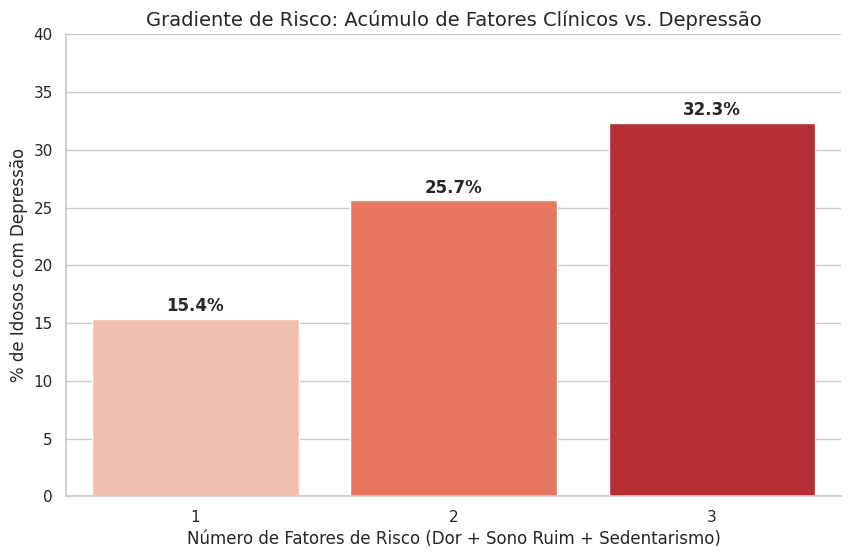

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando o gráfico de barras
plt.figure(figsize=(10,6))
ax = sns.barplot(x=analise_real.index, y=analise_real.values, palette='Reds')

# Adicionando os números em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.title('Gradiente de Risco: Acúmulo de Fatores Clínicos vs. Depressão', fontsize=14)
plt.xlabel('Número de Fatores de Risco (Dor + Sono Ruim + Sedentarismo)', fontsize=12)
plt.ylabel('% de Idosos com Depressão', fontsize=12)
plt.ylim(0, 40) # Dá espaço para os números no topo
sns.despine() # Deixa o gráfico mais limpo e moderno
plt.show()